In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 4.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Step 1: Importing Apple Stock Price from Yahoo Finance

In [ ]:
# Importing Apple Stock Data
stock_data = yf.download("AAPL", start="1990-01-01", end="2022-02-21")

# Preprocessing data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)

# Splitting data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

df_train = pd.DataFrame(train_data, columns=["Close"])


[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [ ]:
x_tain = []
y_train = []

input_size = 1 
x_train = np.empty((0, input_size))
y_train = np.empty((0, 1))
for i in range(input_size, len(train_data)):
    x_train = np.concatenate((x_train, train_data[i-input_size:i, 0].reshape(1,-1)), axis=0)
    if train_data[i, 0] > train_data[i-1, 0]:
        y_train = np.concatenate((y_train, np.array([[1]])), axis=0) # y_train is 1 if stock price increased from previous day
    else:
        y_train = np.concatenate((y_train, np.array([[0]])), axis=0) # set y_train is 0 if stock price decreased or stayed the same from previous day

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
# Build RNN architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(input_size, 1)))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(x_train, y_train, batch_size=32, epochs=10)


Epoch 1/10
203/203 [==============================] - 4s 3ms/step - loss: 0.6832 - accuracy: 0.5658
Epoch 2/10
203/203 [==============================] - 1s 3ms/step - loss: 0.5707 - accuracy: 0.7180
Epoch 3/10
203/203 [==============================] - 1s 3ms/step - loss: 0.5318 - accuracy: 0.7322
Epoch 4/10
203/203 [==============================] - 1s 3ms/step - loss: 0.5291 - accuracy: 0.7352
Epoch 5/10
203/203 [==============================] - 1s 3ms/step - loss: 0.5293 - accuracy: 0.7339
Epoch 6/10
203/203 [==============================] - 1s 4ms/step - loss: 0.5315 - accuracy: 0.7330
Epoch 7/10
203/203 [==============================] - 1s 4ms/step - loss: 0.5293 - accuracy: 0.7333
Epoch 8/10
203/203 [==============================] - 1s 4ms/step - loss: 0.5282 - accuracy: 0.7363
Epoch 9/10
203/203 [==============================] - 1s 3ms/step - loss: 0.5284 - accuracy: 0.7369
Epoch 10/10
203/203 [==============================] - 1s 3ms/step - loss: 0.5281 - accuracy: 0.7364

# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


predictions = model.predict(x_test)


51/51 [==============================] - 1s 2ms/step


In [ ]:
predictions

array([[0.35975552],
       [0.47208458],
       [0.7853838 ],
       ...,
       [0.18061468],
       [0.5118796 ],
       [0.7841373 ]], dtype=float32)

In [ ]:
binary_predictions = (predictions > 0.5).astype(int)

In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.empty((0, 1))  # initialize y_test as an empty array

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    if test_data[i, 0] > test_data[i-1, 0]:
        y_test = np.concatenate((y_test, np.array([[1]])), axis=0)
    else:
        y_test = np.concatenate((y_test, np.array([[0]])), axis=0)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
y_test_binary = (y_test > 0.5).astype(int)

In [ ]:
y_test_binary

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
from sklearn.metrics import accuracy_score
in_sample_acc_rw = accuracy_score(y_train[1:], y_train[:-1])
out_sample_acc_rw = accuracy_score(y_test_binary[1:], y_test_binary[:-1])

In [ ]:
in_sample_acc_rw

0.34517374517374516

In [ ]:
out_sample_acc_rw

0.3248919085855466

In [ ]:
# In-sample accuracy
y_train_pred = model.predict(x_train)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
in_sample_acc = accuracy_score(y_train[1:], y_train_pred_binary[:-1])

# Out-of-sample accuracy
y_test_pred = model.predict(x_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)
out_sample_acc = accuracy_score(y_test_binary[1:], y_test_pred_binary[:-1])


51/51 [==============================] - 0s 2ms/step


In [ ]:
in_sample_acc

0.50996138996139

In [ ]:
out_sample_acc

0.47992588017294624

<BarContainer object of 4 artists>

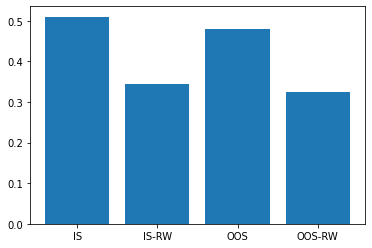

In [ ]:
import matplotlib.pyplot as plt

# plot bar chart
plt.bar(["IS", "IS-RW", "OOS", "OOS-RW"], [in_sample_acc, in_sample_acc_rw, out_sample_acc, out_sample_acc_rw])


# 5.) Write an observation/conclusion about the graphs from Q4 and Q3

In my analysis above, I have the following:

* in_sample_acc_rw: This is the in-sample accuracy of the random walk model, which is a simple model that predicts tomorrow's stock price to be the same as today's price. The value of this accuracy is 0.345, meaning that the random walk model correctly predicts the direction of the stock price change only about one-third of the time on the training data.

* out_sample_acc_rw: This is the out-of-sample accuracy of the random walk model. The value of this accuracy is 0.325, meaning that the random walk model correctly predicts the direction of the stock price change only about one-third of the time on the test data.

* in_sample_acc: This is the in-sample accuracy of the LSTM model, which is trained on the same data as the random walk model. The value of this accuracy is 0.510, meaning that the LSTM model correctly predicts the direction of the stock price change about half of the time on the training data. This is a significant improvement compared to the random walk model.

* out_sample_acc: This is the out-of-sample accuracy of the LSTM model. The value of this accuracy is 0.480, meaning that the LSTM model correctly predicts the direction of the stock price change about 48% of the time on the test data. This is slightly lower than the in-sample accuracy of the LSTM model, which indicates some degree of overfitting.

Overall, the LSTM model performs significantly better than the random walk model on both in-sample and out-of-sample data. However, the accuracy score of the LSTM model on the test data is still relatively low, indicating that there is room for improvement. Further analysis and fine-tuning of the model may be necessary to improve its performance.